# Necessary Libraries


In [ ]:
import pandas as pd
import re
import string
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model
# from  matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

# Reading DataSet

In [2]:
data = pd.read_csv("spam(madeof).csv",encoding = "'latin'")

In [3]:
data.head()

,v1,v2
0,ham,Subject: enron methanol ; meter # : 988291\nth...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [4]:
data["spam"] = data.v1
data["text"] = data.v2

# Splitting data

In [5]:
emails_train, emails_test, target_train, target_test = train_test_split(data.text, data.spam, test_size = 0.2) 

In [6]:
data.info

<bound method DataFrame.info of         v1  ...                                               text
0      ham  ...  Subject: enron methanol ; meter # : 988291\nth...
1      ham  ...  Subject: hpl nom for january 9 , 2001\r\n( see...
2      ham  ...  Subject: neon retreat\r\nho ho ho , we ' re ar...
3     spam  ...  Subject: photoshop , windows , office . cheap ...
4      ham  ...  Subject: re : indian springs\r\nthis deal is t...
...    ...  ...                                                ...
5166   ham  ...  Subject: put the 10 on the ft\r\nthe transport...
5167   ham  ...  Subject: 3 / 4 / 2000 and following noms\r\nhp...
5168   ham  ...  Subject: calpine daily gas nomination\r\n>\r\n...
5169   ham  ...  Subject: industrial worksheets for august 2000...
5170  spam  ...  Subject: important online banking alert\r\ndea...

[5171 rows x 4 columns]>

In [7]:
emails_train.shape

(4136,)

In [8]:
data.describe()


,v1,v2,spam,text
count,5171,5171,5171,5171
unique,2,4993,2,4993
top,ham,Subject: calpine daily gas nomination\r\n>\r\n...,ham,Subject: calpine daily gas nomination\r\n>\r\n...
freq,3672,20,3672,20


In [9]:
data.corr()


""


# Preprocessing

In [ ]:
def remove_hyperlink(word):
    return  re.sub(r'http\S+', '', word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,
                      remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

x_train[0]

In [12]:
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [13]:
train_y


array([0, 0, 1, ..., 0, 0, 1])

# Tokenize

In [14]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [15]:
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]

[15,
 363,
 32,
 158,
 5,
 340,
 252,
 938,
 1549,
 1,
 141,
 363,
 32,
 747,
 5,
 3447,
 190,
 5,
 340,
 8,
 60,
 178,
 2925,
 1549,
 1,
 141,
 363,
 32,
 747,
 5,
 1,
 1787,
 190,
 3448,
 26,
 272,
 5,
 340,
 8,
 60,
 178,
 96,
 5,
 1,
 170,
 162,
 6,
 1,
 108,
 1156,
 5,
 1,
 10307,
 6,
 1,
 108,
 1787,
 190,
 21,
 18,
 292,
 227,
 340]

# Padding

In [16]:
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([  0,   0,   0, ..., 292, 227, 340], dtype=int32)

# Model

In [17]:
embedding_vecor_length = 32

#**LSTM** 

In [18]:
# LSTM
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(tf.keras.layers.LSTM(64))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 32)          1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,625,889
Trainable params: 1,625,889
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# LSTM
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_split=0.2)

Epoch 1/20
7/7 [==============================] - 85s 11s/step - loss: 0.6874 - accuracy: 0.6346 - val_loss: 0.6568 - val_accuracy: 0.7367
Epoch 2/20
7/7 [==============================] - 79s 11s/step - loss: 0.6390 - accuracy: 0.7142 - val_loss: 0.5602 - val_accuracy: 0.7367
Epoch 3/20
7/7 [==============================] - 72s 10s/step - loss: 0.5626 - accuracy: 0.7078 - val_loss: 0.5189 - val_accuracy: 0.7367
Epoch 4/20
7/7 [==============================] - 74s 11s/step - loss: 0.4991 - accuracy: 0.7104 - val_loss: 0.4088 - val_accuracy: 0.7367
Epoch 5/20
7/7 [==============================] - 72s 10s/step - loss: 0.3626 - accuracy: 0.7289 - val_loss: 0.2744 - val_accuracy: 0.8623
Epoch 6/20
7/7 [==============================] - 76s 11s/step - loss: 0.2640 - accuracy: 0.9480 - val_loss: 0.2304 - val_accuracy: 0.9408
Epoch 7/20
7/7 [==============================] - 71s 10s/step - loss: 0.2167 - accuracy: 0.9882 - val_loss: 0.2064 - val_accuracy: 0.9348
Epoch 8/20
7/7 [===========

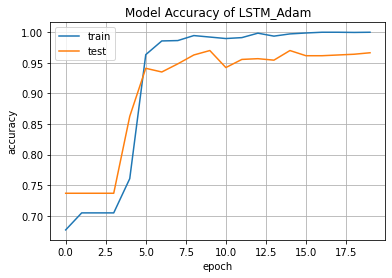

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of LSTM_Adam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#Confusion Matrix

In [21]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [22]:
cf_matrix =confusion_matrix(test_y,y_predict)

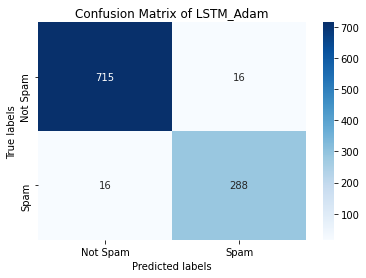

In [23]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix of LSTM_Adam'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [24]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [25]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 94.74%
Recall: 94.74%
F1 Score: 94.74%


In [26]:
f1_score(test_y,y_predict)

0.9473684210526315

#**Bi-LSTM**

In [27]:
# Bilstm
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 32)          1600000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
# BiLSTM
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_split=0.2)

Epoch 1/20
7/7 [==============================] - 233s 33s/step - loss: 0.6878 - accuracy: 0.5691 - val_loss: 0.6506 - val_accuracy: 0.7367
Epoch 2/20
7/7 [==============================] - 167s 23s/step - loss: 0.6408 - accuracy: 0.7031 - val_loss: 0.5602 - val_accuracy: 0.7367
Epoch 3/20
7/7 [==============================] - 131s 18s/step - loss: 0.5802 - accuracy: 0.7110 - val_loss: 0.5342 - val_accuracy: 0.7367
Epoch 4/20
7/7 [==============================] - 221s 30s/step - loss: 0.5356 - accuracy: 0.7009 - val_loss: 0.4314 - val_accuracy: 0.7367
Epoch 5/20
7/7 [==============================] - 251s 36s/step - loss: 0.4029 - accuracy: 0.7117 - val_loss: 0.3127 - val_accuracy: 0.8635
Epoch 6/20
7/7 [==============================] - 264s 37s/step - loss: 0.3014 - accuracy: 0.9501 - val_loss: 0.2799 - val_accuracy: 0.9517
Epoch 7/20
7/7 [==============================] - 231s 34s/step - loss: 0.2939 - accuracy: 0.9670 - val_loss: 0.3369 - val_accuracy: 0.9287
Epoch 8/20
7/7 [====

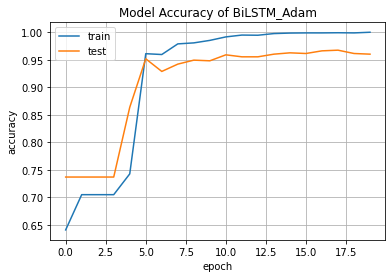

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of BiLSTM_Adam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#Confusion Matrix BiLSTM


In [30]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [32]:
cf_matrix =confusion_matrix(test_y,y_predict)

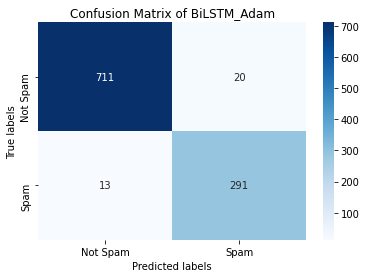

In [33]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix of BiLSTM_Adam'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [34]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [35]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 93.57%
Recall: 95.72%
F1 Score: 94.63%


In [36]:
f1_score(test_y,y_predict)

0.9463414634146342

#**GRU**

In [37]:
#GRU
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
# model.add(GRU(units=64, dropout=0.1,recurrent_dropout=0.1))
model.add(tf.keras.layers.GRU(64))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 32)          1600000   
_________________________________________________________________
gru (GRU)                    (None, 64)                18816     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,619,873
Trainable params: 1,619,873
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# GRU
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_split=0.2)

Epoch 1/20
7/7 [==============================] - 55s 8s/step - loss: 0.6909 - accuracy: 0.5556 - val_loss: 0.6748 - val_accuracy: 0.7367
Epoch 2/20
7/7 [==============================] - 53s 8s/step - loss: 0.6709 - accuracy: 0.7012 - val_loss: 0.6426 - val_accuracy: 0.7367
Epoch 3/20
7/7 [==============================] - 52s 7s/step - loss: 0.6362 - accuracy: 0.7023 - val_loss: 0.5808 - val_accuracy: 0.7367
Epoch 4/20
7/7 [==============================] - 52s 7s/step - loss: 0.5716 - accuracy: 0.7109 - val_loss: 0.5050 - val_accuracy: 0.7367
Epoch 5/20
7/7 [==============================] - 53s 8s/step - loss: 0.5145 - accuracy: 0.7062 - val_loss: 0.4445 - val_accuracy: 0.7428
Epoch 6/20
7/7 [==============================] - 52s 7s/step - loss: 0.4222 - accuracy: 0.7176 - val_loss: 0.3301 - val_accuracy: 0.7899
Epoch 7/20
7/7 [==============================] - 52s 7s/step - loss: 0.2736 - accuracy: 0.8597 - val_loss: 0.2387 - val_accuracy: 0.9034
Epoch 8/20
7/7 [==================

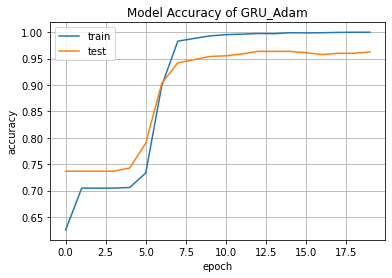

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of GRU_Adam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#Confusion Matrix GRU


In [40]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [41]:
cf_matrix =confusion_matrix(test_y,y_predict)

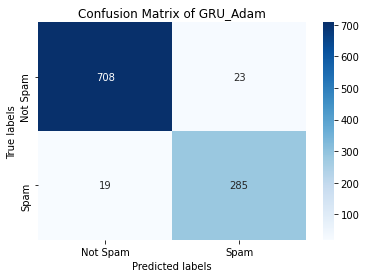

In [42]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix of GRU_Adam'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [43]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [44]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 92.53%
Recall: 93.75%
F1 Score: 93.14%


In [45]:
f1_score(test_y,y_predict)

0.9313725490196078